## M-T airway models -- idealised & virtual twins

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from collections import defaultdict

### Constants, Variables and mapping

In [56]:
locations = ['IN', 'OC', 'PH', 'LA', 'TR', 'OU']

models = ['AJ','VC', 'US', 'PP' ]

test_models = ['VC', 'AJ']

velocity_measure_types = ['LR', 'TD']

flow_rates = [15, 30] 

model_to_bendradius = {'AJ': 0.045,'VC': 0.063, 'US': 0.02, 'PP': 0.05}

######################################################
#density (kg/m3)
rho = 1.225

#viscosity (kg/m.s)
viscosity= 0.000017894
######################################################

# reynolds number == density (kg/m3) x Dh (m) x Vmag (m2/s) / viscosity (kg/m.s)
# dean number == Dh (m) x Sqrt ( Re / (2 x Bend Radius (m)))


### Names and formatting

In [57]:
model_to_name = { 
    'VC': 'VCU',  # Circle
    'US': 'USP',  # square               
    'AJ': 'VT01',  # Triangle up
    'PP': 'VT02'   # Triangle down
}


model_to_color = { 
      'AJ': '#0096FF', #midnight blue 
      'VC': '#228B22', #green
      'US': '#AA336A', #pink
      'PP': '#FFD700'  #gold
}
model_to_marker = { 
    'VC': 'o',  # Circle
    'US': 's',  # square               
    'AJ': '^',  # Triangle up
    'PP': 'v'   # Triangle down
}


location_to_fullname = {\
      'IN': 'Inlet',
      'OC': 'Oral Cavity',
      'PH': 'Pharynx', 
      'LA': 'Larynx',
      'TR': 'Trachea', 
      'OU': 'Outlet'
}

direction_to_style =  {\
      'TD': '-', 
      'LR': '-.'
}



## Calculate perimeter, area, & hydraulic diameter

In [58]:
# first read the files under condition and read the data as a table
# dictionary mapping
# filename -> table


# SURFACE AREA ##########################################################
dfsa = defaultdict(dict)
for model in models:
    for location in locations: 
        name = f"{location}-SA-{model}.csv"
        if os.path.exists(name):
            table = pd.read_csv(name)
            dfsa[model][location] = table['Area'].to_numpy()[0]
          
          
# Perimeter ##########################################################            
dfp = defaultdict(dict)
for model in models:
    for location in locations: 
        name = f"{location}-PE-{model}.csv"
        if os.path.exists(name):
            table = pd.read_csv(name)
            dfp[model][location] = table.max().to_numpy()[0] 
                  
   
# Hydraulic Diameter ##########################################################        
hydraulic_diameter = {model: {location: 4 * dfsa[model][location] / dfp[model][location] for location in locations} for model in models}

## Get the velocity on slice mapping

In [59]:
velocities_across_locations = defaultdict(dict)

for model in models:
    for location in locations:
        for flow_rate in flow_rates: 
            for type in velocity_measure_types:
                name = f"{location}-VEL-{model}-{flow_rate}-{type}.csv"
                if os.path.exists(name):
                    df = pd.read_csv(name)
                    df = df.dropna()

                    # read velocity and perform the calculation
                    df['VelocityMagnitude'] = (df['VELOC:0']**2 + df['VELOC:1']**2 + df['VELOC:2']**2)**0.5
                    df['NormalizedLength']= (df['arc_length'] - df['arc_length'].min()) / (df['arc_length'].max() - df['arc_length'].min())
                    
                    # drop columns we don't need
                    clean_dataframe = df[['VelocityMagnitude', 'NormalizedLength']]
                    if location not in velocities_across_locations[model]:
                        velocities_across_locations[model][location] = defaultdict(dict)
                    velocities_across_locations[model][location][flow_rate][type] = clean_dataframe        

## TKE 

In [60]:
dftke = defaultdict(dict)
for model in models:
    for flow_rate in flow_rates:
        for location in locations: 
            name = f"{location}-TKE-{model}-{flow_rate}.csv"
            if os.path.exists(name):
                table = pd.read_csv(name)
                if location not in dftke[model]:
                    dftke[model][location] = {}
                dftke[model][location][flow_rate] = table['AVVE2_Magnitude'].to_numpy()[0]                   

dftke

defaultdict(dict,
            {'AJ': {'IN': {15: 0.000178268, 30: 0.000734539},
              'OC': {15: 0.000153405, 30: 0.000583573},
              'PH': {15: 0.00119531, 30: 0.0047866},
              'LA': {15: 0.000970437, 30: 0.00245683},
              'TR': {15: 0.000385806, 30: 0.00131542},
              'OU': {15: 0.000233618, 30: 0.000920519}},
             'VC': {'IN': {15: 0.000158516, 30: 0.000663723},
              'OC': {15: 0.000148373, 30: 0.000643508},
              'PH': {15: 0.000102328, 30: 0.000450311},
              'LA': {15: 0.000553511, 30: 0.00224015},
              'TR': {15: 0.000388636, 30: 0.00135922},
              'OU': {15: 0.00033592, 30: 0.00121482}},
             'US': {'IN': {15: 0.00023847, 30: 0.000971063},
              'OC': {15: 0.000254482, 30: 0.00102026},
              'PH': {15: 0.000323814, 30: 0.00116772},
              'LA': {15: 0.000273234, 30: 0.00104834},
              'TR': {15: 0.000254019, 30: 0.00106385},
              'OU': {15:

## Big dataframe of all values

In [61]:
df_list = []
for model in  models:
    for location in locations:
        for flow_rate in flow_rates: 
           # print(f"Processing {model} {location} {flow_rate}")
            # calculate the mean velocity through
            # different crossing of the slice 
            # and average them
            mean_values = []
            for type in velocity_measure_types: 
                velocity_at_flow = velocities_across_locations[model][location][flow_rate][type]
                mean_value = velocity_at_flow['VelocityMagnitude'].mean()
                mean_values.append(mean_value)
            mean_velocity = np.mean(mean_values)    
            
            
            row_df = {'Model': model, 
                'BendRadius': model_to_bendradius[model],
                'Location': location,
                'Area': dfsa[model][location],
                "Perimeter": dfp[model][location],
                "Dh": hydraulic_diameter[model][location],
                "TKE": dftke[model][location][flow_rate],
                "FlowRate": flow_rate, 
                "AvgVelocity": mean_velocity}     
            df_list.append(row_df)
            

df = pd.DataFrame(df_list)
df

,Model,BendRadius,Location,Area,Perimeter,Dh,TKE,FlowRate,AvgVelocity
0,AJ,0.045,IN,0.000357,0.072248,0.019758,0.000178,15,0.703014
1,AJ,0.045,IN,0.000357,0.072248,0.019758,0.000735,30,1.428220
2,AJ,0.045,OC,0.000780,0.129057,0.024171,0.000153,15,0.504633
3,AJ,0.045,OC,0.000780,0.129057,0.024171,0.000584,30,1.084878
4,AJ,0.045,PH,0.000072,0.043948,0.006513,0.001195,15,3.000558
5,AJ,0.045,PH,0.000072,0.043948,0.006513,0.004787,30,7.833392
6,AJ,0.045,LA,0.000269,0.064902,0.016592,0.000970,15,1.551267
7,AJ,0.045,LA,0.000269,0.064902,0.016592,0.002457,30,2.516374
8,AJ,0.045,TR,0.000221,0.056843,0.015552,0.000386,15,1.343701
9,AJ,0.045,TR,0.000221,0.056843,0.015552,0.001315,30,2.766423


## Compute Reynolds and Dean number 

In [62]:
# Re Number

df["Re"] = rho * df['Dh']*df['AvgVelocity'] / viscosity


# Dean Number
df['De'] = df['Re']*np.sqrt(df['Dh'] / (2*df['BendRadius']))

In [63]:
# #AVERAGE VEL MAG 3
# dfvm = defaultdict(dict)
# for model in models:
#     for location in locations:
#         for flow_rate in flow_rates:
#             name = f"{location}-VM-{model}--{flow_rate}.csv"
#             if os.path.exists(name):
#                 table = pd.read_csv(name)
#                 # initialise dictionary if not created
#                 if location not in dfvm[model]:
#                     dfvm[model][location] = {}
#                 dfvm[model][location][flow_rate] = table.mean().to_numpy()[0]
# df_list = []
# for model in dfvm.keys():
#     for location in dfvm[model].keys():
#         for flow_rate in dfvm[model][location].keys(): 
#             velocity = dfvm[model][location][flow_rate]
#             row_df = {'Model': model, 
#                 'Location': location,
#                 'BendRadius': model_to_bendradius[model],
#                 'Area': dfsa[model][location],
#                 "Perimeter": dfp[model][location],
#                 "Dh": hydraulic_diameter[model][location],
#                 "FlowRate": flow_rate                }     
#             df_list.append(row_df)
# extra_df = pd.DataFrame(df_list)
#  #add to the original one            
# df = pd.concat([df, extra_df])



In [64]:
#average velocity 2
#df['AvgVelocity2'] = (df['FlowRate']/60000) / (math.pi * ((df['Dh'] / 2)**2))

# Re Number
#df['Re'] = rho * df['Dh']*df['AvgVelocity'] / viscosity

# Re Number 2
#df['Re2'] = rho * df['Dh']*df['AvgVelocity2'] / viscosity


# Dean Number
#df['De'] = df['Re']*np.sqrt(df['Dh'] / (2*df['BendRadius']))

# Curvature Ratio
#df['Ro']= df['BendRadius']/ (df['Dh']/2)

In [65]:
df

,Model,BendRadius,Location,Area,Perimeter,Dh,TKE,FlowRate,AvgVelocity,Re,De
0,AJ,0.045,IN,0.000357,0.072248,0.019758,0.000178,15,0.703014,950.884163,445.526854
1,AJ,0.045,IN,0.000357,0.072248,0.019758,0.000735,30,1.428220,1931.785603,905.117990
2,AJ,0.045,OC,0.000780,0.129057,0.024171,0.000153,15,0.504633,835.029414,432.742120
3,AJ,0.045,OC,0.000780,0.129057,0.024171,0.000584,30,1.084878,1795.174476,930.323646
4,AJ,0.045,PH,0.000072,0.043948,0.006513,0.001195,15,3.000558,1337.797255,359.872644
5,AJ,0.045,PH,0.000072,0.043948,0.006513,0.004787,30,7.833392,3492.513644,939.499700
6,AJ,0.045,LA,0.000269,0.064902,0.016592,0.000970,15,1.551267,1762.066814,756.579642
7,AJ,0.045,LA,0.000269,0.064902,0.016592,0.002457,30,2.516374,2858.320619,1227.278770
8,AJ,0.045,TR,0.000221,0.056843,0.015552,0.000386,15,1.343701,1430.600910,594.690266
9,AJ,0.045,TR,0.000221,0.056843,0.015552,0.001315,30,2.766423,2945.333623,1224.353502


In [73]:
#merged_df = pd.merge(df, extra_df, on=['Model', 'Location', 'BendRadius','Perimeter', 'Area', 'FlowRate', 'Dh'])

# Re Number 3
#merged_df['Re3'] = rho * merged_df['Dh']*merged_df['MaxVelocity'] / viscosity



## Add Re and De to dataframe

In [74]:
df

,Model,BendRadius,Location,Area,Perimeter,Dh,TKE,FlowRate,AvgVelocity,Re,De
0,AJ,0.045,IN,0.000357,0.072248,0.019758,0.000178,15,0.703014,950.884163,445.526854
1,AJ,0.045,IN,0.000357,0.072248,0.019758,0.000735,30,1.428220,1931.785603,905.117990
2,AJ,0.045,OC,0.000780,0.129057,0.024171,0.000153,15,0.504633,835.029414,432.742120
3,AJ,0.045,OC,0.000780,0.129057,0.024171,0.000584,30,1.084878,1795.174476,930.323646
4,AJ,0.045,PH,0.000072,0.043948,0.006513,0.001195,15,3.000558,1337.797255,359.872644
5,AJ,0.045,PH,0.000072,0.043948,0.006513,0.004787,30,7.833392,3492.513644,939.499700
6,AJ,0.045,LA,0.000269,0.064902,0.016592,0.000970,15,1.551267,1762.066814,756.579642
7,AJ,0.045,LA,0.000269,0.064902,0.016592,0.002457,30,2.516374,2858.320619,1227.278770
8,AJ,0.045,TR,0.000221,0.056843,0.015552,0.000386,15,1.343701,1430.600910,594.690266
9,AJ,0.045,TR,0.000221,0.056843,0.015552,0.001315,30,2.766423,2945.333623,1224.353502


## Only Model, Location, AveV, Re and De data      my_columns

In [75]:
my_columns = list(df.columns.values)
my_columns.remove('BendRadius')
#my_columns.remove('Area')
my_columns.remove('Perimeter')
#my_columns.remove('Dh')
#my_columns.remove('FlowRate')
#my_columns.remove('Ro')
#my_columns.remove('Re')
#my_columns.remove('De')
#my_columns.remove('Type')
df[my_columns]

,Model,Location,Area,Dh,TKE,FlowRate,AvgVelocity,Re,De
0,AJ,IN,0.000357,0.019758,0.000178,15,0.703014,950.884163,445.526854
1,AJ,IN,0.000357,0.019758,0.000735,30,1.428220,1931.785603,905.117990
2,AJ,OC,0.000780,0.024171,0.000153,15,0.504633,835.029414,432.742120
3,AJ,OC,0.000780,0.024171,0.000584,30,1.084878,1795.174476,930.323646
4,AJ,PH,0.000072,0.006513,0.001195,15,3.000558,1337.797255,359.872644
5,AJ,PH,0.000072,0.006513,0.004787,30,7.833392,3492.513644,939.499700
6,AJ,LA,0.000269,0.016592,0.000970,15,1.551267,1762.066814,756.579642
7,AJ,LA,0.000269,0.016592,0.002457,30,2.516374,2858.320619,1227.278770
8,AJ,TR,0.000221,0.015552,0.000386,15,1.343701,1430.600910,594.690266
9,AJ,TR,0.000221,0.015552,0.001315,30,2.766423,2945.333623,1224.353502


In [76]:
df[(df['FlowRate'] == 30) ]

,Model,BendRadius,Location,Area,Perimeter,Dh,TKE,FlowRate,AvgVelocity,Re,De
1,AJ,0.045,IN,0.000357,0.072248,0.019758,0.000735,30,1.428220,1931.785603,905.117990
3,AJ,0.045,OC,0.000780,0.129057,0.024171,0.000584,30,1.084878,1795.174476,930.323646
5,AJ,0.045,PH,0.000072,0.043948,0.006513,0.004787,30,7.833392,3492.513644,939.499700
7,AJ,0.045,LA,0.000269,0.064902,0.016592,0.002457,30,2.516374,2858.320619,1227.278770
9,AJ,0.045,TR,0.000221,0.056843,0.015552,0.001315,30,2.766423,2945.333623,1224.353502
11,AJ,0.045,OU,0.000291,0.062345,0.018686,0.000921,30,2.092942,2677.352580,1219.956021
13,VC,0.063,IN,0.000550,0.083202,0.026418,0.000664,30,1.148248,2076.643509,950.879472
15,VC,0.063,OC,0.000836,0.102566,0.032620,0.000644,30,0.959401,2142.444608,1090.096187
17,VC,0.063,PH,0.000891,0.111136,0.032056,0.000450,30,0.580307,1273.490803,642.340386
19,VC,0.063,LA,0.000125,0.040932,0.012218,0.002240,30,4.680104,3914.554455,1218.978745


## Create plots on different locations

In [77]:
#show or save plots
show = True

====Creating plot for IN 15====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


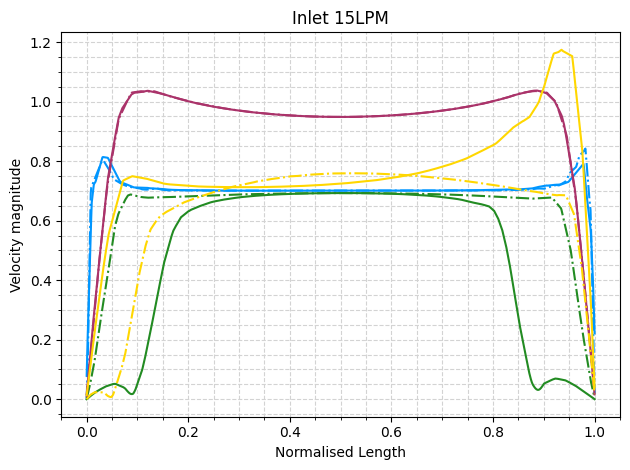

====Creating plot for IN 30====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


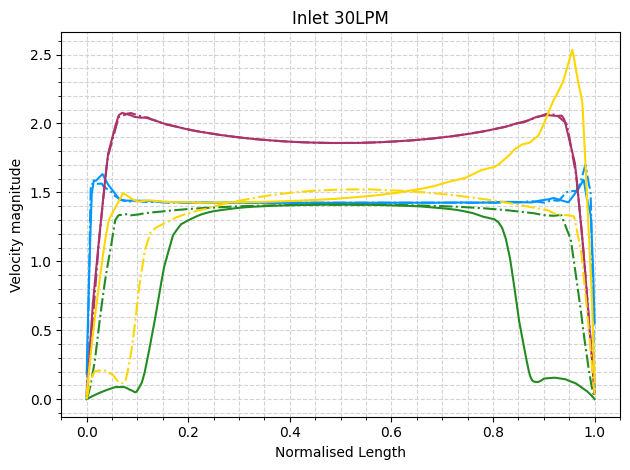

====Creating plot for OC 15====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


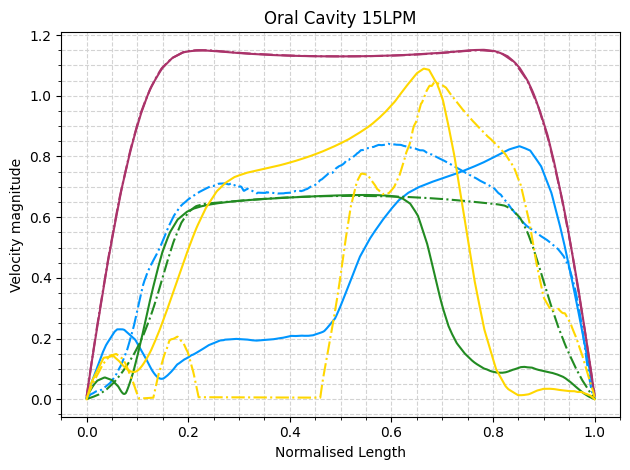

====Creating plot for OC 30====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


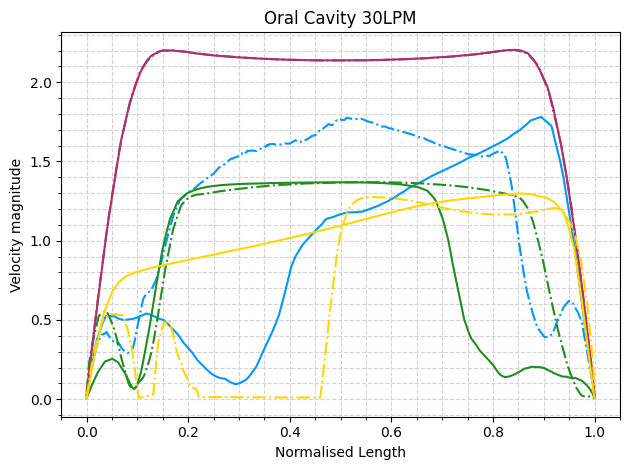

====Creating plot for PH 15====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


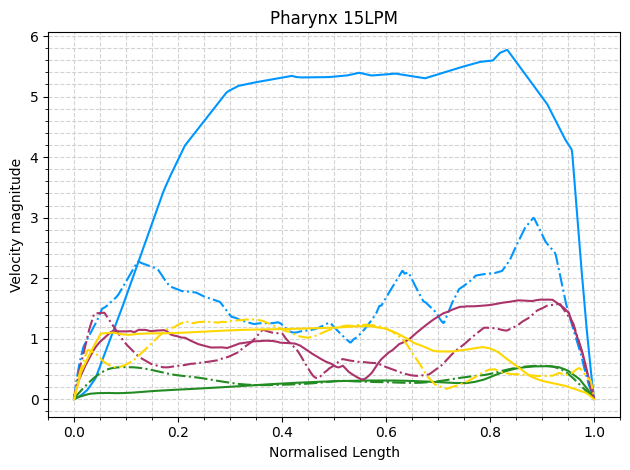

====Creating plot for PH 30====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


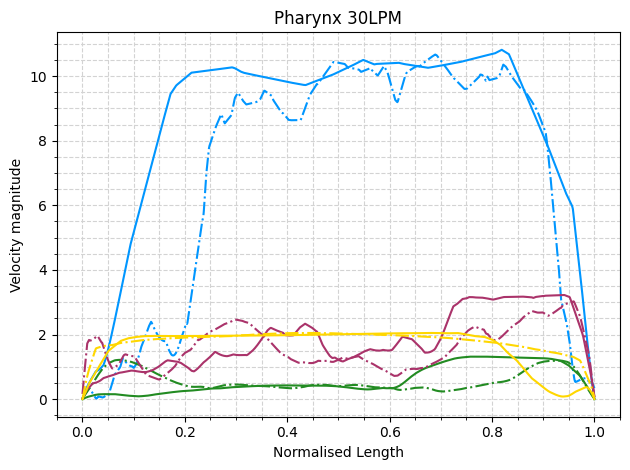

====Creating plot for LA 15====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


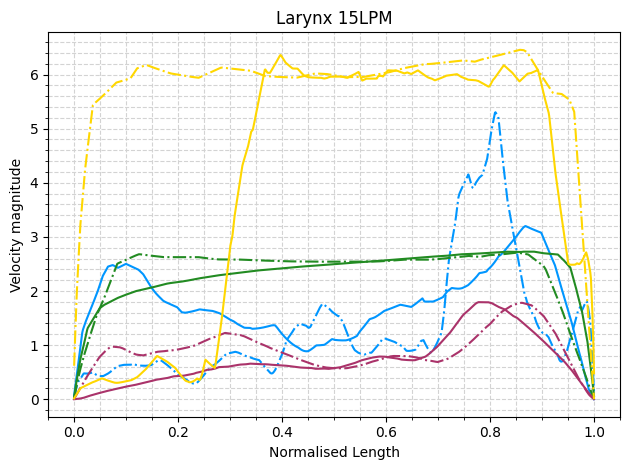

====Creating plot for LA 30====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


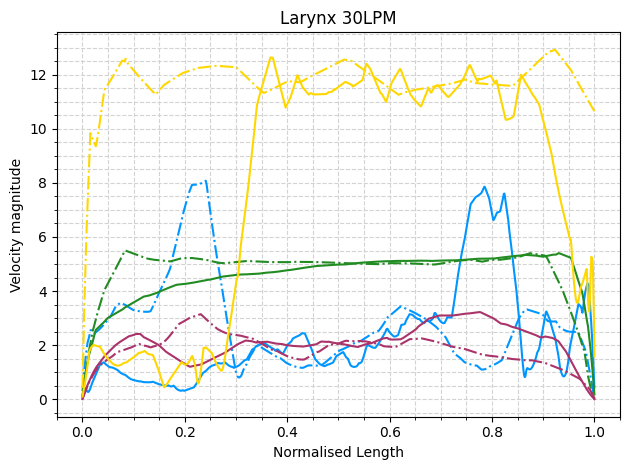

====Creating plot for TR 15====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


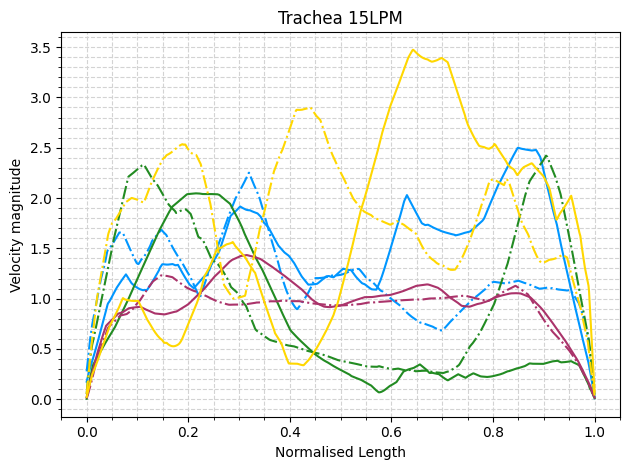

====Creating plot for TR 30====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


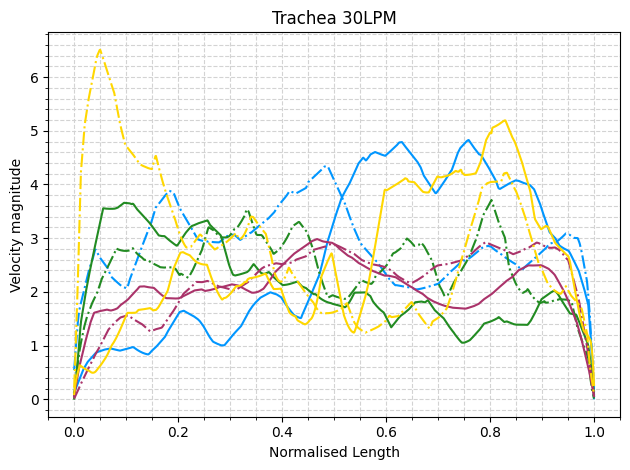

====Creating plot for OU 15====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


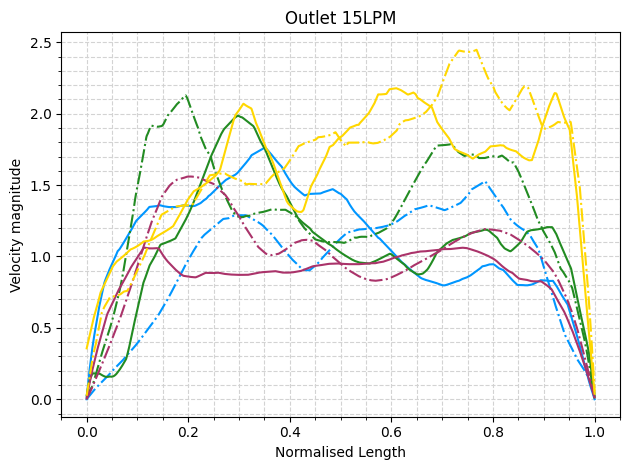

====Creating plot for OU 30====
Creating line for AJ LR
Creating line for AJ TD
Creating line for VC LR
Creating line for VC TD
Creating line for US LR
Creating line for US TD
Creating line for PP LR
Creating line for PP TD


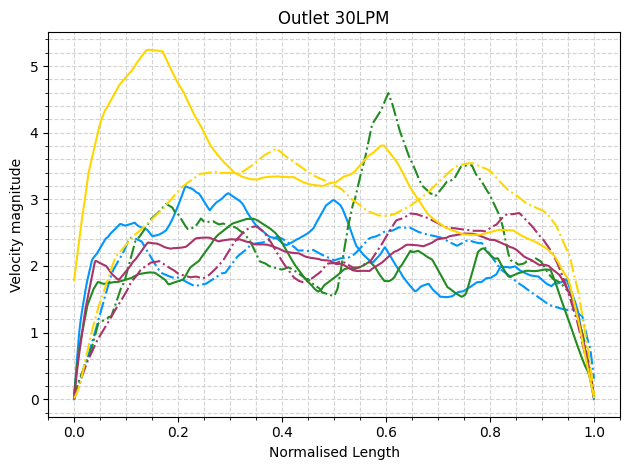

In [78]:
for location in locations: 
      for flow_rate in flow_rates: 
            # normal length plotting
            fig, ax = plt.subplots()
            location_fullname = location_to_fullname[location]
            title = f"{location_fullname} {flow_rate}LPM"
            
            print(f"====Creating plot for {location} {flow_rate}====")
            
            # plot velocities for every model and TD or LR velocity
            for model in models:
                  for type in velocity_measure_types:
                        print(f"Creating line for {model} {type}")
                        label = f"{model} {type}"

                        local_df = velocities_across_locations[model][location][flow_rate][type]
                        ax.plot(local_df['NormalizedLength'], local_df['VelocityMagnitude'],
                                label = label, 
                                color=model_to_color[model], 
                                linestyle=direction_to_style[type])
            
            
            ax.set_title(title)      
            ax.set(xlabel='Normalised Length', ylabel='Velocity magnitude')
         #   plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            ax.grid(linestyle = 'dashed', color = 'lightgrey')
            ax.grid( which='minor', linestyle = 'dashed', color = 'lightgrey')
            ax.minorticks_on()

            if show: 
                  plt.show()
            else: 
                  filename = f"{location_fullname.lower()}-{flow_rate}.png"
                  plt.savefig(filename)

### Clean table with data

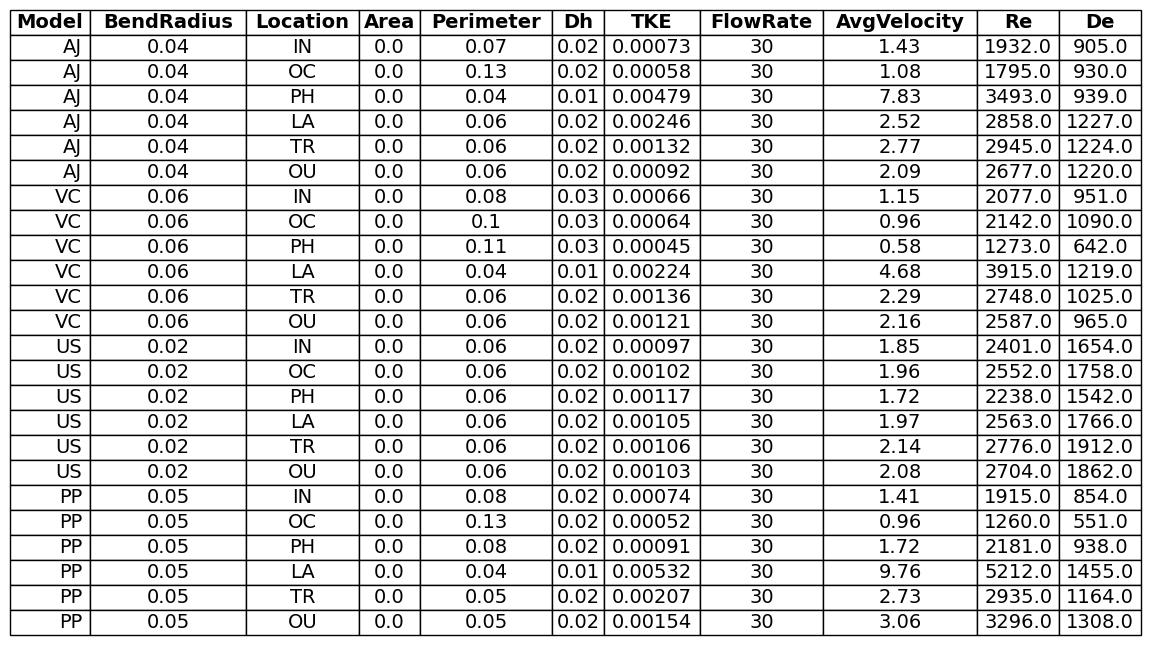

In [89]:
# Create a figure and axis
fig, ax = plt.subplots()

# Hide axes
ax.axis('off')

# Select rows with FlowRate equal to 15
f1_df = df[df['FlowRate'] ==30]
#filtered_df = f1_df[df['Model'] =='AJ']
# Select columns to keep
columns_to_keep = ['Model', 'Location', 'AvgVelocity', 'aV', 'Re', 'De', 'TKE']
#filtered_df = f1_df[columns_to_keep]

#decimal places
decimal_places = 2
formatted_df = f1_df.round(decimal_places)
formatted_df['TKE'] = f1_df['TKE'] 
# Create the table
table = ax.table(cellText=formatted_df.values, colLabels=formatted_df.columns, loc='center')


# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(14)

# Adjust cell heights
table.auto_set_column_width(col=list(range(len(df.columns))))
table.scale(1, 1.5)  # Increase cell height

# Center-align cell text
for (i, j), cell in table._cells.items():
    if (i == 0):
        cell.set_text_props(fontweight='bold', color='black')
    else:
        cell.set_text_props(color='black')
    if (i > 0 and j > 0):
        cell.set_text_props(ha='center')
        
# Show the plot
plt.show()

# Plot Reynolds No. Dean No. and TKE

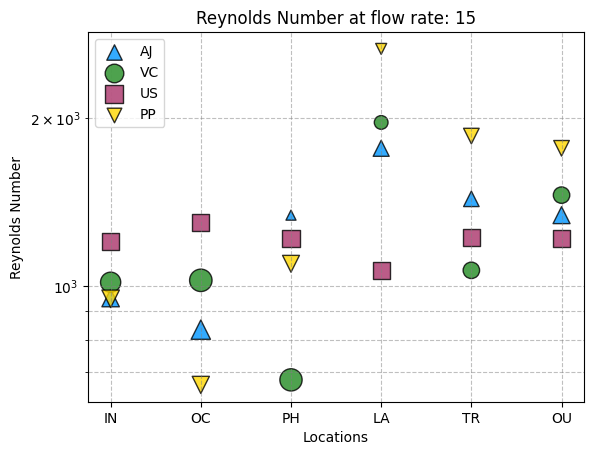

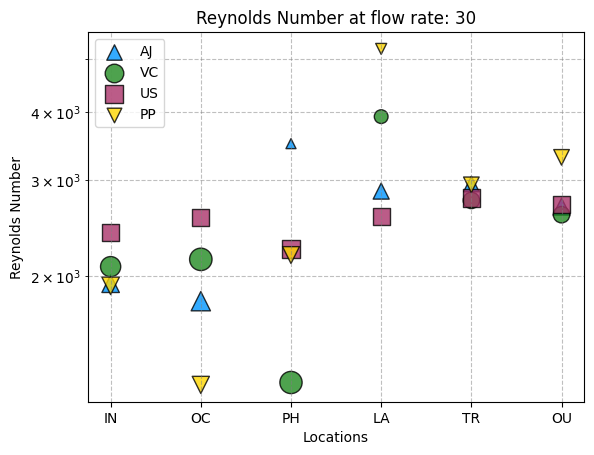

In [91]:

for flow_rate in flow_rates:
    flow_df = df[df['FlowRate'] == flow_rate] 
    
    fig, ax = plt.subplots() # Create a new figure for each flow_rate
    
    for model in models: 
        model_df = flow_df[flow_df['Model'] == model]
        ax.scatter(
            model_df['Location'], 
            model_df['Re'], 
            s=model_df['Dh']*8000,  # Size based on hydraulic diameter
            color=model_to_color[model], 
            label=f"{model}",
            alpha=0.8,  # Slightly transparent markers
            edgecolor='black',  # Marker outlines
            marker=model_to_marker[model]  # Marker shape
        )

    # Adding labels and title
    ax.set_xlabel('Locations')
    ax.set_ylabel('Reynolds Number')
    ax.set_title(f'Reynolds Number at flow rate: {flow_rate}')
    ax.legend(loc='upper left')
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', color='grey', alpha=0.5, which='both')
    # Displaying the plot
    plt.show()

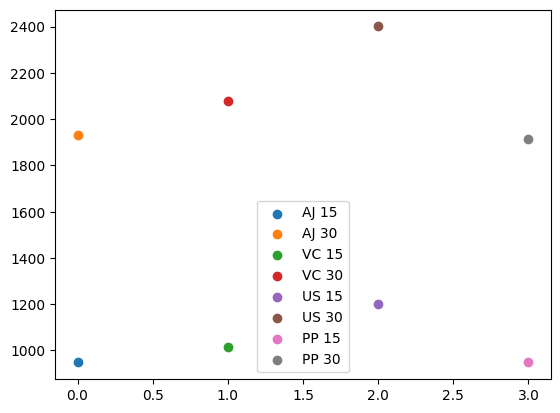

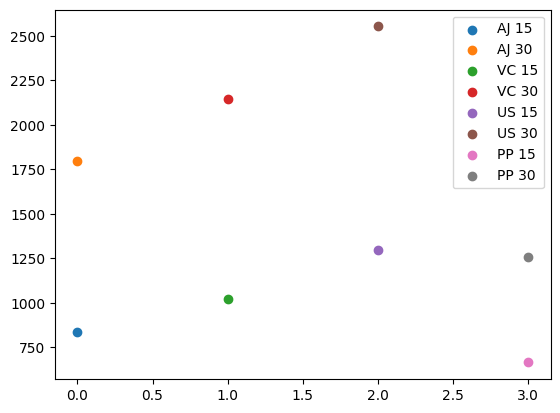

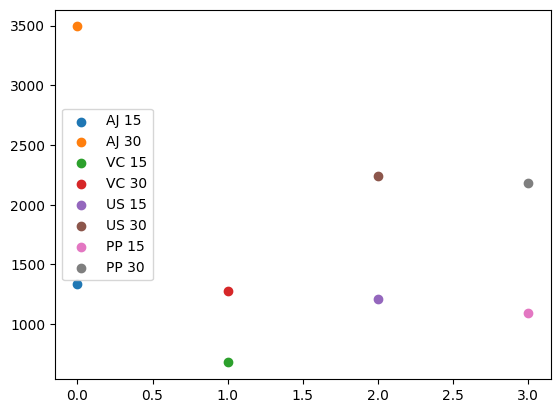

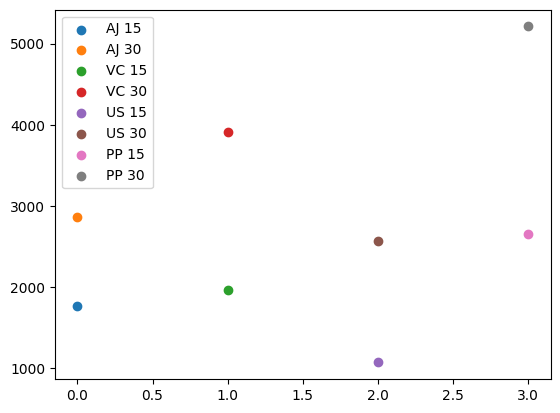

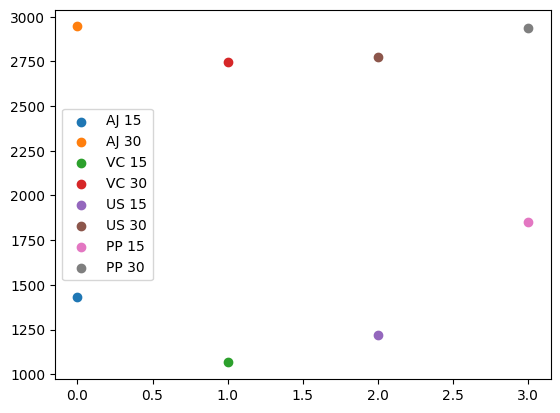

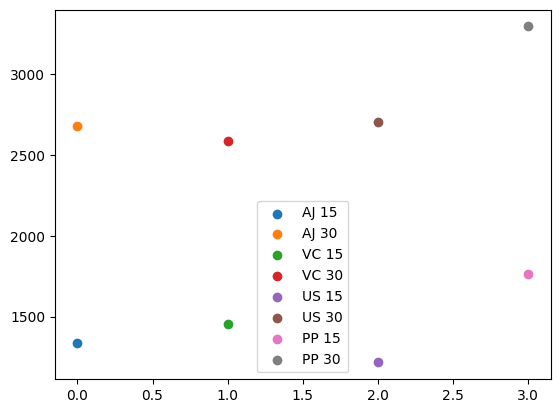

In [ ]:
for location in locations: 
      location_df = df[df['Location'] == location ]
      
      fig, ax = plt.subplots()
      for i, model in enumerate(models): 
            for flow_rate in flow_rates: 
                  label = f'{model} {flow_rate}'
                  ax.scatter(i, location_df[(location_df['Model'] == model) & (location_df['FlowRate'] == flow_rate) ]['Re'],
                             label = label)
                  
      plt.legend()
      plt.show()

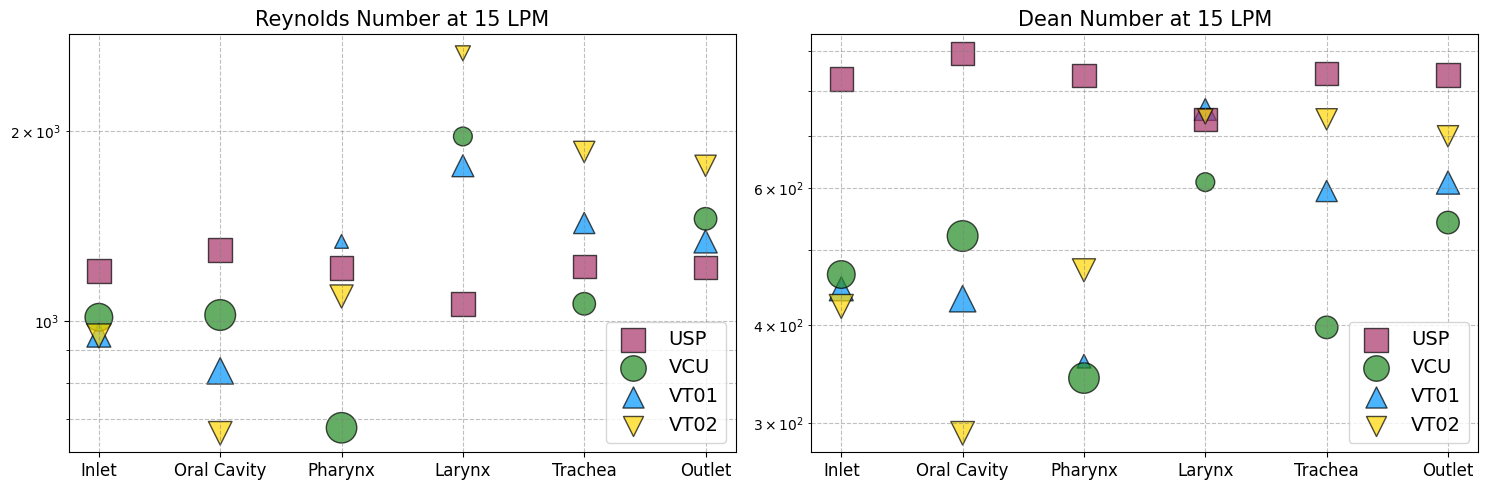

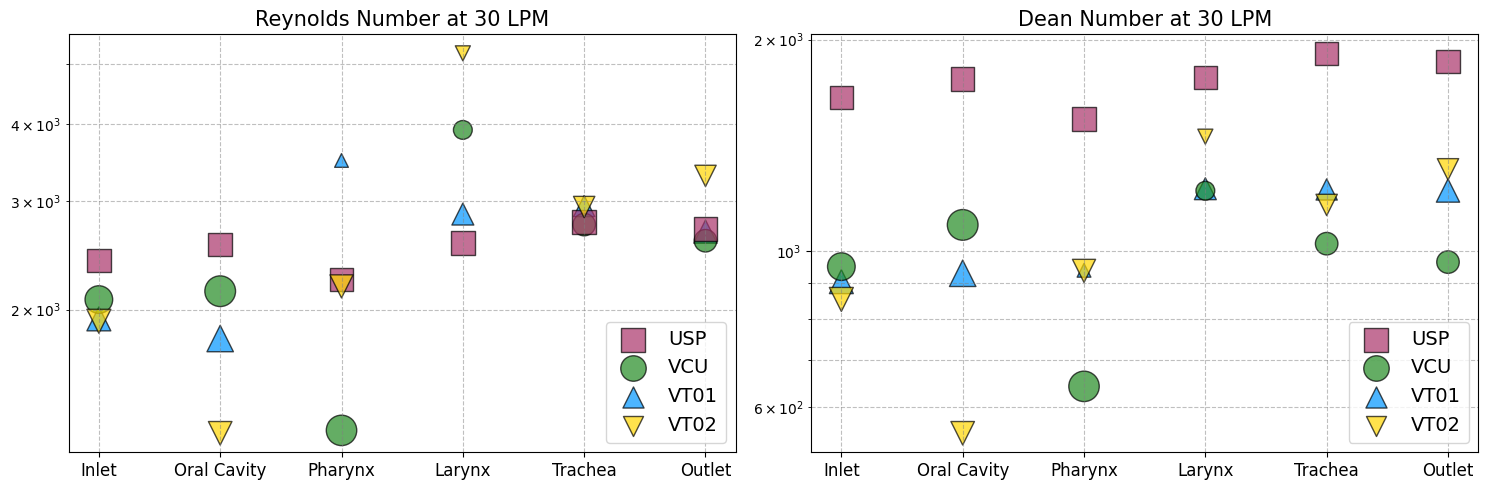

In [ ]:
def plot_data(ax, x, y, size, color, label, marker):
    ax.scatter(
        x, 
        y, 
        s=size, 
        color=color, 
        label=label,
        alpha=0.7,  
        edgecolor='black',  
        marker=marker
    )
    handles, labels = ax.get_legend_handles_labels()
    handles_sorted, labels_sorted = zip(*sorted(zip(handles, labels), key=lambda t: t[1]))  # Sort labels
    ax.legend(handles_sorted, labels_sorted, loc='lower right', prop={'size': 14})
    ax.grid(True, linestyle='--', color='grey', alpha=0.5, which='both')

def plot_for_variable(ax, df, variable, ylabel):
    for model in models: 
        model_df = df[df['Model'] == model]
        plot_data(
            ax, 
            model_df['Location'].map(location_to_fullname),
            model_df[variable], 
            size=model_df['Dh'] * 15000,  # Size multiplied by 12000 and using Dh
            color=model_to_color[model], 
            label=model_to_name[model],
            marker=model_to_marker[model],  # Marker shape
            
        )
    ax.tick_params(axis='x', labelsize=12)
    #ax.set_xlabel('Locations', fontsize=14)
    #ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(f'{ylabel} at {flow_rate} LPM', fontsize=15)
    ax.grid(True, linestyle='--', color='grey', alpha=0.5, which='both')

for flow_rate in flow_rates:
    flow_df = df[df['FlowRate'] == flow_rate] 
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5)) # Create a new figure with three subplots
        
    for ax in axs:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale
    
    plot_for_variable(axs[0], flow_df, 'Re', 'Reynolds Number')
    plot_for_variable(axs[1], flow_df, 'De', 'Dean Number')

    # Additional plot (Add your own code here for the third plot)

    plt.tight_layout()
    plt.show()

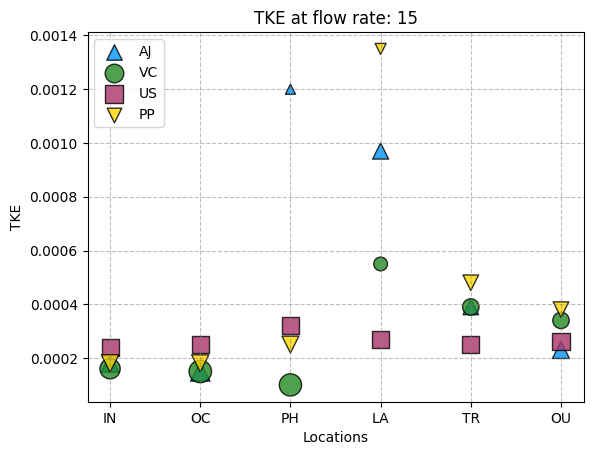

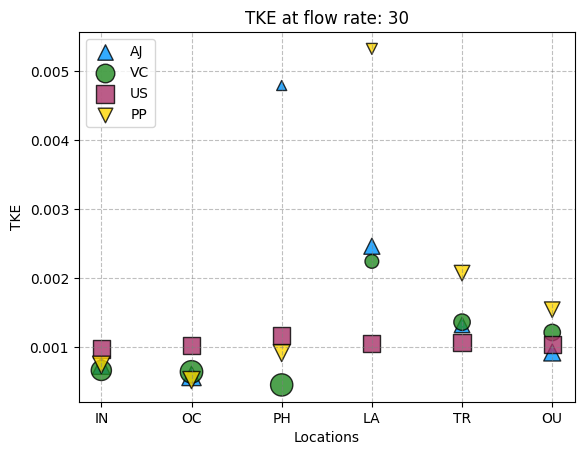

In [93]:

for flow_rate in flow_rates:
    flow_df = df[df['FlowRate'] == flow_rate] 
    
    fig, ax = plt.subplots() # Create a new figure for each flow_rate
    
    for model in models: 
        model_df = flow_df[flow_df['Model'] == model]
        ax.scatter(
            model_df['Location'], 
            model_df['TKE'], 
            s=model_df['Dh']*8000,  # Size based on hydraulic diameter
            color=model_to_color[model], 
            label=f"{model}",
            alpha=0.8,  # Slightly transparent markers
            edgecolor='black',  # Marker outlines
            marker=model_to_marker[model]  # Marker shape
        )

    # Adding labels and title
    ax.set_xlabel('Locations')
    ax.set_ylabel('TKE')
    ax.set_title(f'TKE at flow rate: {flow_rate}')
    ax.legend(loc='upper left')
    #ax.set_yscale('log')
    ax.grid(True, linestyle='--', color='grey', alpha=0.5, which='both')
    # Displaying the plot
    plt.show()

# Literature Results

In [ ]:
reference_df = pd.read_csv('literature_results.csv')

In [ ]:
reference_df['Type'] = 'Reference' 
df['Type'] = 'Simulation'

In [ ]:
full_df = pd.concat([df, reference_df])
full_df

,Model,BendRadius,Location,Area,Perimeter,Dh,FlowRate,AvgVelocity,AvgVelocity2,Re,Re2,De,Ro,Type,PAPER REF
0,AJ,0.045,IN,0.000357,0.072248,0.019758,15.0,0.703014,0.815417,950.884163,1102.919282,445.526854,4.555200,Simulation,NaN
1,AJ,0.045,IN,0.000357,0.072248,0.019758,30.0,1.428220,1.630835,1931.785603,2205.838564,905.117990,4.555200,Simulation,NaN
2,AJ,0.045,OC,0.000780,0.129057,0.024171,15.0,0.504633,0.544823,835.029414,901.532701,432.742120,3.723447,Simulation,NaN
3,AJ,0.045,OC,0.000780,0.129057,0.024171,30.0,1.084878,1.089646,1795.174476,1803.065401,930.323646,3.723447,Simulation,NaN
4,AJ,0.045,PH,0.000072,0.043948,0.006513,15.0,3.000558,7.504659,1337.797255,3345.948140,359.872644,13.819201,Simulation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Xi & Longest 2007 - Elliptical,NaN,OC,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,Reference,NaN
70,Xi & Longest 2007 - Elliptical,NaN,PH,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,Reference,NaN
71,Xi & Longest 2007 - Elliptical,NaN,LA,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,Reference,NaN
72,Xi & Longest 2007 - Elliptical,NaN,TR,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,Reference,NaN


In [ ]:
results_with_reynolds = full_df[full_df['Re'].notnull()]